# imports

In [1]:
import pandas as pd
# import sklearn
# import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
# from sklearn. import
import matplotlib.pyplot as plt


# Initial data handling
distance_from_home - the distance from home where the transaction happened.

distance_from_last_transaction - the distance from last transaction happened.

ratio_to_median_purchase_price - Ratio of purchased price transaction to median purchase price.

repeat_retailer - Is the transaction happened from same retailer.

used_chip - Is the transaction through chip (credit card).

used_pin_number - Is the transaction happened by using PIN number.

online_order - Is the transaction an online order.

fraud - Is the transaction fraudulent.

In [2]:
df = pd.read_csv("card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Checking for duplicates before splitting to avoid data leakage
assert (len(df) == len(df.drop_duplicates()))

In [5]:
def split_data(df, target=None):
    
    if target == None:
        target = list(df.columns)[-1]
    return df.drop(columns=[target], axis=1), df[[target]]

def nan_ratio_col(df, col):
    nan_ratio = sum(df[col].isna()) / len(df[col])
    return nan_ratio

In [6]:
# Splitting training and validation data
X, y = split_data(df)


# Feature engineering:

The best data scientist displays their value in the handling of data BEFORE the modelling stage.

feature engineering ideas:

- jumping_transaction bool = (distance_from_last_transaction in 80th percentile ) & online_order
- chip_and_pin = used_chip & used_pin_number
- distance_from_home
- repeat_retailer
- ratio_to_median_purchase_price


In [7]:
# jumping_transaction
distant_transaction_threshold = X["distance_from_home"].quantile(.75)
distant_transaction = X["distance_from_home"] > distant_transaction_threshold
X['jumping_transaction'] = (distant_transaction & X["online_order"]).astype(int)

In [8]:
#chip_and_pin
X["chip_and_pin"] = (X["used_chip"].astype(int) & X["used_pin_number"].astype(int))
X["chip_and_pin"].value_counts()

chip_and_pin
0    964947
1     35053
Name: count, dtype: int64

In [9]:
# drop cols used in feature engineering to avoid multicolinearity/excess noise with no 
# increased predictive power
final_features = ["chip_and_pin", "jumping_transaction", "distance_from_home", "repeat_retailer", "ratio_to_median_purchase_price"]
X = X[final_features]
X

,chip_and_pin,jumping_transaction,distance_from_home,repeat_retailer,ratio_to_median_purchase_price
0,0,0,57.877857,1.0,1.945940
1,0,0,10.829943,1.0,1.294219
2,0,0,5.091079,1.0,0.427715
3,0,0,2.247564,1.0,0.362663
4,0,1,44.190936,1.0,2.222767
...,...,...,...,...,...
999995,0,0,2.207101,1.0,1.626798
999996,0,0,19.872726,1.0,2.778303
999997,0,0,2.914857,1.0,0.218075
999998,0,0,4.258729,1.0,0.475822


(array([8.99423e+05, 6.27940e+04, 1.83130e+04, 7.82400e+03, 4.09700e+03,
        2.23400e+03, 1.47900e+03, 9.64000e+02, 6.38000e+02, 4.78000e+02]),
 array([  0.,  60., 120., 180., 240., 300., 360., 420., 480., 540., 600.]),
 <BarContainer object of 10 artists>)

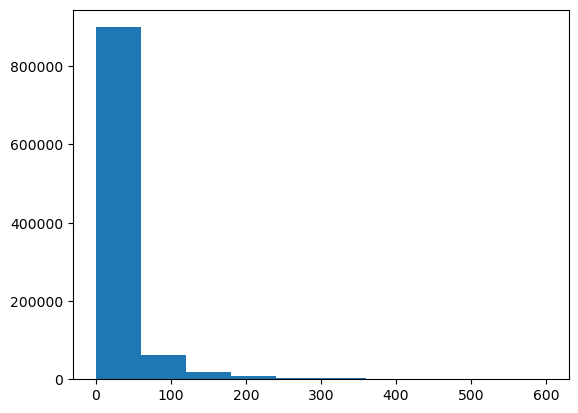

In [10]:
plt.hist(x=X["distance_from_home"],range=(0,600))

# Scaling effect of this feature down...
# Use minmax scaler because the skewness of the distance from home is essiential information to our model
# and because we will try parametric models
# scaler = MinMaxScaler(feature_range=(0, 1))
# X[["distance_from_home"]] = scaler.fit_transform(X[["distance_from_home"]])


# plt.hist(x=X["distance_from_home"],range=(0.2,1))


# Handling imbalanced dataset
The data is incredibly imbalanced. With fraudulent cases making up only ~10% of our samples. Oversampling would create excess noise, that I think is unnecessary so I'll use undersampling. With only 5 features, and more than 87000 samples in the minority class, I believe the model will have enough data to learn to differentiate each class. 

In [11]:
y.value_counts()

fraud
0.0      912597
1.0       87403
Name: count, dtype: int64

In [12]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resample, y_resample = rus.fit_resample(X, y)

In [13]:
y_resample.value_counts()

fraud
0.0      87403
1.0      87403
Name: count, dtype: int64

In [14]:
# due to scale incongruencies between features I will use a tree based model
from sklearn.ensemble import RandomForestClassifier


In [15]:
# splitting train/test and val datasets on resampled data
X_train_rs, X_val_rs, y_train_rs, y_val_rs = train_test_split(
    X_resample, y_resample, test_size=0.2, random_state=42)


In [16]:
# random search, grid search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'max_samples': [0.7, 0.8, 0.9, None],
    'min_impurity_decrease': [0.0, 0.0001, 0.001]
}

rs_obj = RandomizedSearchCV(
    RandomForestClassifier(), 
    distributions, 
    n_iter=2, 
    scoring="f1", 
    n_jobs=-1, 
    cv=2,
    random_state=42,
    )

In [ ]:
rs_obj.fit(X_train_rs, y_train_rs)

/home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was pa

In [ ]:
pd.DataFrame(rs_obj.cv_results_)